## Essencial Functions and Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import tifffile as tiff
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score


## Read data

In [ ]:
from pathlib import Path
import numpy as np
import tifffile as tiff

# Main directory of the dataset
dataset_dir = Path('spotlite_dataset_loca1_date1_dir1')

# Subdirectories for images and masks
images_dir = dataset_dir / 'images'
masks_dir  = dataset_dir / 'masks'

# Check if the folders exist
assert images_dir.exists(), f"Image folder not found: {images_dir}"
assert masks_dir.exists(),  f"Mask folder not found: {masks_dir}"

# List all .tif (or .tiff) files and sort them by base name
image_paths = sorted(images_dir.glob('*.tif*'), key=lambda p: p.stem)
mask_paths  = sorted(masks_dir.glob('*.tif*'),  key=lambda p: p.stem)

# Create a dictionary {base_name: mask_path}
mask_dict = {p.stem: p for p in mask_paths}

imgs, masks = [], []
missing_masks = []
extra_masks = set(mask_dict.keys())

for img_path in image_paths:
    stem = img_path.stem
    if stem not in mask_dict:
        missing_masks.append(img_path.name)
        continue

    mask_path = mask_dict[stem]
    extra_masks.discard(stem)

    # Read image and mask
    img  = tiff.imread(str(img_path))   # shape (H, W, C)
    msk  = tiff.imread(str(mask_path))  # shape (H, W)

    # Check dimension consistency
    if img.shape[:2] != msk.shape:
        raise ValueError(
            f"Incompatible dimensions for {img_path.name} and {mask_path.name}: "
            f"image {img.shape[:2]}, mask {msk.shape}"
        )

    imgs.append(img)
    masks.append(msk)

# If images without corresponding masks are found
if missing_masks:
    raise FileNotFoundError(
        f"Missing masks for the following images:\n  " +
        "\n  ".join(missing_masks)
    )

# If there are masks without corresponding images
if extra_masks:
    print("Warning: some masks do not have corresponding images:",
          ", ".join(sorted(extra_masks)))

# Group into numpy arrays
imgs_array  = np.stack(imgs, axis=0)   # (N, H, W, C)
masks_array = np.stack(masks, axis=0)  # (N, H, W)

print(f'Shape of arrays: imgs {imgs_array.shape}, masks {masks_array.shape}')


shape of imgs: (191, 512, 512, 4)
shape of masks: (191, 512, 512)


## Convert labels in masks

In [3]:
# Convert labels in masks from 0, 3, 4 to 0, 1, 2
# where 0 is background, 1 is class 1, and 2 is class
def remap_mask(mask):
    if not torch.is_tensor(mask):
        mask = torch.from_numpy(mask)
    remapped = torch.zeros_like(mask)
    remapped[mask == 0] = 0
    remapped[mask == 3] = 1
    remapped[mask == 4] = 2
    return remapped.long()

masks = remap_mask(masks)

print(f'shape of remapped masks: {masks.shape}')

shape of remapped masks: torch.Size([191, 512, 512])


## Extract features and labels

In [4]:
N, H, W, C = imgs.shape
X = imgs.reshape(-1, C)       # shape = (N*H*W, 4)
y = masks.reshape(-1)         # shape = (N*H*W,)

print(f'shape of X: {X.shape}')
print(f'shape of y: {y.shape}')

# (Opcional) amostragem para acelerar treino
# idx = np.random.choice(len(y), size=100000, replace=False)
# X, y = X[idx], y[idx]

shape of X: (50069504, 4)
shape of y: torch.Size([50069504])


## Check Inbalance

Classe 0: 48,043,641 pixels (95.95%)
Classe 1: 687,567 pixels (1.37%)
Classe 2: 1,338,296 pixels (2.67%)
   class    counts    percent
0      0  48043641  95.953898
1      1    687567   1.373225
2      2   1338296   2.672876


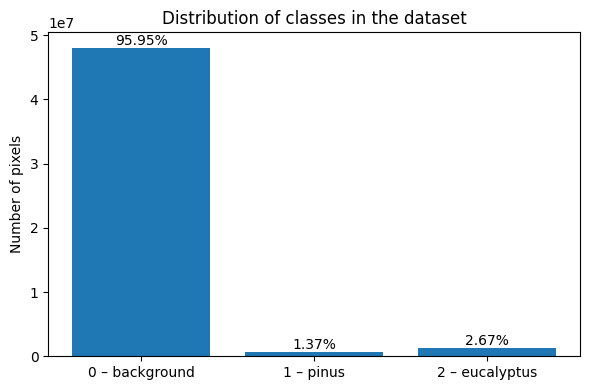

In [5]:
y = np.array(y)

y_flat = y.reshape(-1)
total_pixels = y_flat.size
classes, counts = np.unique(y_flat, return_counts=True)

for cls, ct in zip(classes, counts):
    pct = ct / total_pixels * 100
    print(f"Classe {cls}: {ct:,} pixels ({pct:.2f}%)")

df_dist = pd.DataFrame({
    "class":   classes,
    "counts":  counts,
    "percent": counts / total_pixels * 100
})
print(df_dist)

class_names = {
    0: "background",
    1: "pinus",
    2: "eucalyptus"
}
x_labels = [f"{cls} – {class_names[cls]}" for cls in df_dist['class']]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(df_dist['class'], df_dist['counts'])

ax.set_ylabel('Number of pixels')
ax.set_title('Distribution of classes in the dataset')

ax.set_xticks(df_dist['class'])
ax.set_xticklabels(x_labels)

for bar, pct in zip(bars, df_dist['percent']):
    x  = bar.get_x() + bar.get_width()/2
    y  = bar.get_height()
    ax.text(x, y, f"{pct:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Split training/testing

In [6]:
# Ensure y is the correct array-like object
y = masks.reshape(-1)  # Restore y to its original form
y = np.array(y)
X = np.array(X, dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f'shape of X_train: {X_train.shape}')
print(f'shape of y_train: {y_train.shape}')
print(f'shape of X_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')

shape of X_train: (37552128, 4)
shape of y_train: (37552128,)
shape of X_test: (12517376, 4)
shape of y_test: (12517376,)


### Train Random Forest 

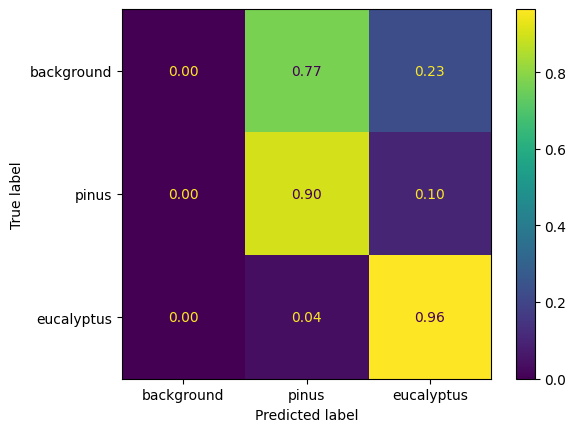

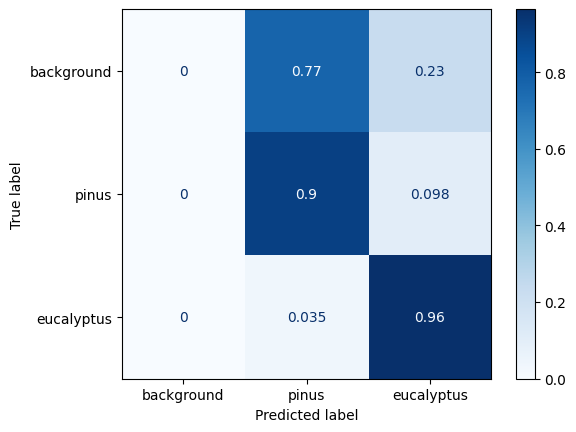

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# ja testei aqui com otimização de hiperparâmetros baysiana, mas deu o mesmo resultado com essa forma simples

sample_weights = np.ones_like(y_train, dtype=float)
# zera o peso onde o label é 0
sample_weights[y_train == 0] = 0.0

rf = RandomForestClassifier(
    n_estimators=20,
    max_depth=15,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = rf.predict(X_test)

print("=== Classification Report ===")
print(classification_report(
  y_test, y_pred,
  target_names=['Background', 'Pinus', 'Eucalyptus'], digits=4
))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    normalize='true',
    display_labels=['background','pinus','eucalyptus'],
    values_format='.2f'      
).plot(cmap='Blues')
